In [1]:
import numpy as np
import theano
import theano.tensor as T
import scipy.sparse as sp
from theano import sparse
import lasagne
import time
import scipy.stats as stats
from collections import OrderedDict
import sys 
sys.setrecursionlimit(50000)


/Applications/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# Generate a matrix from a multivariate normal distribution with low-rank covariance matrix
KTRUE = 1
K = 5
N = 50
D = 20
maxit = 3*KTRUE*(N+D-KTRUE)
#maxit = N*D

np.random.seed(seed=10)

#c0np = np.random.gamma(1,1)
#gamma0np = np.random.gamma(1,1)
#gammanp = np.random.gamma(1,1)
#rnp = np.random.gamma(gamma0np/KTRUE, c0np, size=(KTRUE))
#w = np.zeros((D,KTRUE))
#for k in range(KTRUE):
#    print(gammanp*rnp[k])
#    print(gammanp)
#    w[:,k] = np.random.gamma(gammanp*rnp[k]+1e-20, gammanp+1e-20, size = (D))
    

w   = np.random.uniform(low=0.0, high=1.0, size=(D,KTRUE))
#Introduce some complexity into w
#w     = np.random.beta(a = 2, b = 5, size = (D,KTRUE))
#maskw = stats.bernoulli.rvs(0.8, size=(D,KTRUE))
#w     = np.multiply(w,maskw)
var = 0.1
covnp = w.dot(w.T)+var*np.eye(D)

Mnp = np.random.multivariate_normal(np.zeros(D), covnp, N).T

In [3]:
maxit

207

In [4]:
random_w_init = np.random.uniform(low=0.01, high=2.0, size=(D,K))
random_r_init = np.random.uniform(low = 0.01, high = 2.0, size = K)

In [5]:
# We use Theano for our model
srng = T.shared_randomstreams.RandomStreams(seed=120)

#Define Theano Variables
Shared = lambda shape,name: theano.shared(value = np.ones(shape,dtype=theano.config.floatX),
                                          name=name,borrow=True) 

In [6]:
rand_index = srng.random_integers(low = 0, high = N-1)

In [10]:
# Let Ynp represent our matrix of partial, noisy observations
#p = 0.03
prob      = 16*(maxit/(N*D))/(20)
#prob = 1
observe = np.random.permutation(np.arange(N*D))[1:int(np.floor(prob*N*D))]
Masknp = np.zeros(N*D)
Masknp[observe] = 1
observerow = np.random.randint(0, high=D, size=np.maximum(N,D))
observecol = np.arange(N)
Masknp = Masknp.reshape((D,N))
Masknp[observerow, observecol] = 1
initial_obs = np.multiply([Masknp!=0], Mnp).flatten()
ratings = initial_obs[initial_obs!=0].tolist()
#p = 0.08
#Masknp = np.random.binomial(N, p, size=(N,D)).T
#Masknp = stats.bernoulli.rvs(p, size=(D,N))
#Masknp[1,:] = 1
Mask   = Shared((D,N), 'Mask')
Mask.set_value(Masknp)
M      = T.as_tensor_variable(Mnp)
Y      = Mask*M
zeroY  = T.as_tensor_variable(np.zeros((D,N)))
zero2  = T.as_tensor_variable(np.zeros((D,D)))
zero   = T.as_tensor_variable(np.zeros(D))
st     = T.sum(T.neq(Y, zeroY), axis = 0)
s      = st.eval()


In [11]:
#Define variables 
W      = Shared((D,K), 'W')
W.set_value(random_w_init)
r      = Shared((K), 'r')
r.set_value(random_r_init)
Gamma  = Shared((1), 'Gamma')
Gamma0 = Shared((1), 'Gamma0')
c0     = Shared((1), 'c0')
sigma  = Shared((1), 'sigma')

t      = T.dscalar('t')

#Define random variables for MVNscan component
zY = srng.normal([D])
zK = srng.normal([K])

#For data given seqentially we need a different covariance matrix for each yn
WWT=T.dot(W, W.T)
Cov=Shared((D,D), 'Cov')
Cov=WWT+sigma[0]*T.identity_like(WWT)
#Cov = T.as_tensor_variable(covnp, name= 'Cov')

#Define lists
mParams = [W, r, Gamma, Gamma0, c0, sigma]

#indexlist = Shared([maxit], 'indexlist')
indexlist = theano.shared(value = np.zeros([maxit,2],dtype=np.int64),
                                          name='indexlist',borrow=True)


In [12]:
#Define Functions for Langevin Step

def logJointScanFn(n, logLikelihood, Y, Cov, Mask):
    
    #idxs          = T.neq(Y[:,n], zero).nonzero()
    #y             = Y[:,n][idxs]
    #idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    
    #littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    #logLikelihood +=(-1/2.0)*T.log(T.nlinalg.Det()(littlecov))-(1/2.0)*T.dot(y.T, T.dot(T.nlinalg.MatrixInverse()(littlecov), y))
    
    #numpy_IncompleteId=np.zeros((D,D))
    #Mask=C.gpu_from_host(T.outer(Yobs_theano[:,n], Yobs_theano[:,n]).reshape((D,D)))
    
    Partial_Cov    = T.outer(Mask[:,n], Mask[:,n])*Cov + (1-Mask[:,n])*T.identity_like(Cov)
    logLikelihood += (-1/2.0)*T.log(T.nlinalg.Det()(Partial_Cov))-(1/2.0)*T.dot(Y[:,n].T, T.dot(T.nlinalg.MatrixInverse()(Partial_Cov), Y[:,n]))
    
    return logLikelihood

def LogJ(mParams, Y, Cov, Mask):

    W, r, Gamma, Gamma0, c0, sigma = mParams
    #LogJt0=time.clock()
    
    results, updates = theano.scan(fn=logJointScanFn,
                                   sequences = np.arange(N),
                                   outputs_info=[dict(initial= np.float64(0) ,taps=[-1])],
                                   non_sequences=[Y, Cov, Mask])
    
    #logLikelihood = sigma[0]
    #for n in range(N):
    #    logLikelihood = logJointScanFn(n, logLikelihood, Y, Cov, s)
    logJoint = results[-1]
    
    #logJoint  = results[-1]
    logJoint2 = ((D*Gamma*T.log(Gamma))[0]*r).sum()-(D*T.gammaln(Gamma[0]*r)).sum()+((Gamma[0]*r-1)*T.log(W)).sum()-(Gamma[0]*W).sum() + (Gamma0*T.log(c0)-K*T.gammaln(Gamma0/K)+(Gamma0/K-1)[0]*(T.log(r)).sum()-(c0[0]*r).sum()-Gamma-Gamma0-c0)[0]
    logJoint  += logJoint2

    return(logJoint)

def adadelta2(loss_or_grads, W, r, Gamma, Gamma0, c0, sigma, learning_rate=1.0, rho=0.95, epsilon=1e-6):
    """ 
    References
    ----------
    .. [1] Zeiler, M. D. (2012):
           ADADELTA: An Adaptive Learning Rate Method.
           arXiv Preprint arXiv:1212.5701.
    """
    params = [W, r, Gamma, Gamma0, c0, sigma]
    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        # accu: accumulate gradient magnitudes
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        # delta_accu: accumulate update magnitudes (recursively!)
        delta_accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                   broadcastable=param.broadcastable)

        # update accu (as in rmsprop)
        accu_new = rho * accu + (one - rho) * grad ** 2
        updates[accu] = accu_new
        #accu = accu_new

        # compute parameter update, using the 'old' delta_accu
        update = (grad * T.sqrt(delta_accu + epsilon) /
                  T.sqrt(accu_new + epsilon))
        #updates[param] = param - learning_rate * update
        updates[param] = T.minimum(T.maximum((param - learning_rate * update).astype(theano.config.floatX), (1e-10)*T.ones_like(param)), 10*T.ones_like(param))
        #param = T.minimum(T.maximum((param - learning_rate * update).astype(theano.config.floatX), (1e-10)*T.ones_like(param)), 10*T.ones_like(param))
        # update delta_accu (as accu, but accumulating updates)
        delta_accu_new = rho * delta_accu + (one - rho) * update ** 2
        updates[delta_accu] = delta_accu_new
        #delta_accu = delta_accu_new

    return updates

def get_or_compute_grads(loss_or_grads, params):
    """Helper function returning a list of gradients
    """
    if any(not isinstance(p, theano.compile.SharedVariable) for p in params):
        raise ValueError("params must contain shared variables only. If it "
                         "contains arbitrary parameter expressions, then "
                         "lasagne.utils.collect_shared_vars() may help you.")
    if isinstance(loss_or_grads, list):
        if not len(loss_or_grads) == len(params):
            raise ValueError("Got %d gradient expressions for %d parameters" %
                             (len(loss_or_grads), len(params)))
        return loss_or_grads
    else:
        return theano.grad(loss_or_grads, params)
    
    
#MVNormalScan constructs our estimate of the entire matrix using conditional multivariate normal

def MVNormalScan_beta02(n, Y, Mask, Cov, W, zY, zK, s):
    
    #construct binaryY_unobs a vector of 1s and 0s where the ith coord is a 1 if we haven't seen the ith coord of y_n    
    binaryY_unobs = T.eq(Y[:,n], zero)
    #construct covariance of the observed entries where the rows/columns with nothing have a 1 on diag (so invertible)
    idxs          = T.neq(Y[:,n], zero).nonzero()
    y             = Y[:,n][idxs]
    idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    littlecov_inv = T.nlinalg.MatrixInverse()(littlecov)
    
    #sigma_observed     = T.outer(binaryY[:,n], binaryY[:,n])*Cov+(binaryY_unobs*T.identity_like(Cov))
    sigma_unobs_obs         = (T.outer(binaryY_unobs, T.neq(Y[:,n], zero)))*Cov
    idxs3                   = T.neq(sigma_unobs_obs, zero2).nonzero()
    little_sigma_unobs_obs = sigma_unobs_obs[:,idxs].reshape((D, s[n])) 
    #sigma_observed_inv = T.nlinalg.MatrixInverse()(sigma_observed)
    dummyY             = T.zeros(D)
    
    #draw the mean vector dummyY from N(0, WWT+sigma^2I) using computationally fast trick
    dummy_results, dummy_updates= theano.scan(lambda prior_result, sigma, zY, W, zK: 
                                              T.sqrt(sigma)[0]*zY+T.dot(W,zK) + prior_result,
                                              sequences=None,
                                              outputs_info= T.zeros(D),
                                              non_sequences=[sigma, zY, W, zK],
                                              n_steps=R)
    
    dummyY       = dummy_results[-1]
    dummyY       /= R
    dummyY_obs   = dummyY[idxs]
    dummyY_unobs = binaryY_unobs*dummyY
    y_est        = dummyY_unobs + T.dot(T.dot(little_sigma_unobs_obs, littlecov_inv), (y-dummyY_obs))
    y_est        = (y_est*binaryY_unobs)-(1e6)*Mask[:,n]
    #y_est        = y_est*binaryY_unobs + Y[:,n]*Mask[:,n]
    
    return [y_est, sigma_unobs_obs, littlecov_inv]


In [13]:
Ytrue = Y.eval()

In [14]:
#Gradient Descent- to do "limit" steps of gradient descent call AdaDeltaStep2()
limit = 200

logJ = LogJ(mParams,Y,Cov, Mask)
[results, mParam_updates] = theano.scan(fn = adadelta2, 
                                      sequences = None,
                                      non_sequences = [-logJ, W, r, Gamma, Gamma0, c0, sigma],
                                      outputs_info = None,
                                      n_steps = limit)

AdaDeltaStep2=theano.function(inputs=[], updates=mParam_updates)

In [15]:
#This serves to test how well, given whatever percent of data observed you set through variable "p", 
#we can estimate the covariance matrix
#% pylab inline
#import numpy as np
#import matplotlib.pyplot as plt
"""
print('Before')
print(Cov.eval())
logJ = LogJ(mParams,Y,Cov, Mask)
print(logJ.eval())
AdaDeltaStep2()
print('After')
print(Cov.eval())
logJ = LogJ(mParams,Y,Cov, Mask)
print(logJ.eval())
"""

"\nprint('Before')\nprint(Cov.eval())\nlogJ = LogJ(mParams,Y,Cov, Mask)\nprint(logJ.eval())\nAdaDeltaStep2()\nprint('After')\nprint(Cov.eval())\nlogJ = LogJ(mParams,Y,Cov, Mask)\nprint(logJ.eval())\n"

In [16]:
if any(not isinstance(p, theano.compile.SharedVariable) for p in mParams):
    print("Strange Error")

In [17]:
def MainBandit2(count, Mask, Masknp, W, r, sigma, Gamma, Gamma0, c0, Y, s, Cov, indexlistnp):
    
    limit = 1000
    R     = 10
    construct_lj_list = 0
    construct_error_list = 0
    tt = time.clock()
        
    logJ = LogJ(mParams,Y,Cov, Mask)
    AdaDeltaStep2()
    #print('adadelta')
    #print(time.clock()-tt)
    
    #[ljlist, errlist, W, r, sigma, Gamma, Gamma0, c0] = SGD(Y, limit,construct_lj_list, construct_error_list, W, r, sigma, Gamma, Gamma0, c0)
    
    #tt = time.clock()
    #sigma.eval()
    #print('update time')
    #print(time.clock()-tt)
    
    # Pick col at random and draw from that column
    #col_ind = rand_index.eval()    
    #[y_est, sigma_unobs_obs, littlecov_inv] = MVNormalScan_beta02(col_ind, Y, Mask, Cov, W, zY, zK, s)
    
    
    [y_est, sigma_u_o_scan, sigma_ob_inv_scan], updates=theano.scan(fn=MVNormalScan_beta02,
                                              sequences=T.arange(N),
                                              outputs_info=None,
                                              non_sequences=[Y, Mask, Cov, W, zY, zK, st])
    
    #print('mvnscan')
    #print(time.clock()-tt)
    #y_est.eval()
    #print('yest time')
    #print(time.clock()-tt)
    
    #y_estnp = 0
    #for rr in range(R):
    #    y_estnp += y_est.eval()
    #y_estnp /= R
    
    #row_ind = np.argmax(y_estnp)
    
    #print('y_estimate')
    #print(y_estimate[1,:].eval())
    tt = time.clock()
    [value, index] = T.max_and_argmax(y_est.T)
    
    indnp = index.eval()
    
    #print('index choice')
    #print(time.clock() - tt)
    
    mf = Masknp.flatten()
    mf[indnp] = 1
    Masknp = mf.reshape((D,N))
    #Masknp[row_ind, col_ind] = 1
    Mask.set_value(Masknp)
    #print('rating')
    #print(Mnp[row_ind, col_ind])
    #print('expected rating')
    #print(y_estnp[row_ind])

    #print(T.size(Mask).eval())
    
    #ON CPU IT MIGHT BE FASTER TO EVAL INDEX EACH ITERATION, BUT PERHAPS USE THEANO INDEXLIST FOR GPU 
    
    #indexlist      = T.set_subtensor(indexlist[count,0], index)
    #indexlist      = T.set_subtensor(indexlist[count,1], n)
    tt = time.clock()
    #indexlistnp[count,0] = row_ind
    #indexlistnp[count,1] = col_ind
    indexlistnp[count] = indnp
    #print('eval time')
    #print(time.clock()-tt)
    #print(r.eval())
    s = st.eval()
    
    
    return Mask, Masknp, W, r, sigma, Gamma, Gamma0, c0, s, Cov, indexlistnp

In [18]:
def ind2sub(array_shape, ind):
    #ind[ind < 0] = -1
    #ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = np.floor(ind / array_shape[1])
    cols = ind % array_shape[1]
    return (int(rows), int(cols))

In [27]:
count     = 0
ratings   = [] 
R         = 20

tt        = time.clock()
indexlistnp = np.zeros(maxit)
for i in range(maxit):
    [Mask, Masknp, W, r, sigma, Gamma, Gamma0, c0, s, Cov, indexlistnp]  = MainBandit2(count, Mask,Masknp, W, r, sigma, Gamma, Gamma0, c0, Y, s, Cov, indexlistnp)
    count = count + 1
    if i%50 == 0 and i>1:
        print("last 50 iters time: {}, Bandit is: {} percent complete.".format(time.clock()-tt, i/maxit))
        tt = time.clock()
    elif i==maxit:
        print("last set of iters time: {}, Bandit is: {} percent complete.".format(time.clock()-tt, i/maxit))
        tt = time.clock()


last 50 iters time: 1.3775960000000396, Bandit is: 0.0, percent complete.
last 50 iters time: 71.80104399999999, Bandit is: 0.24154589371980675, percent complete.
last 50 iters time: 72.6961, Bandit is: 0.4830917874396135, percent complete.
last 50 iters time: 72.98492899999997, Bandit is: 0.7246376811594203, percent complete.
last 50 iters time: 72.87777600000004, Bandit is: 0.966183574879227, percent complete.


In [20]:
indexlistnp

array([ 569.,  977.,  369.,  929.,  919.,  178.,  386.,   32.,  557.,
        928.,  586.,  719.,  160.,  910.,  379.,  576.,  381.,  726.,
        926.,  710.,   11.,   40.,  550.,  590.,  760.,  703.,  729.,
        960.,  378.,  737.,  979.,  376.,  383.,  575.,  740.,  179.,
         29.,  361.,  707.,  676.,  582.,  526.,  978.,   28.,   37.,
        933.,  169.,  587.,  976.,   26.,  572.,  725.,  126.,  736.,
        778.,  940.,  932.,  561.,  190.,   36.,   16.,    0.,  350.,
        551.,  210.,  722.,  153.,  690.,  540.,  990.,  558.,  175.,
        886.,  779.,  554.,   27.,   31.,  700.,  714.,  226.,   45.,
        745.,  528.,  769.,  229.,  186.,   18.,  595.,  594.,  519.,
        975.,   10.,  525.,  360.,   19.,  382.,  565.,  712.,  172.,
        679.,  282.,  503.,  500.,  353.,    3.,  953.,   14.,  387.,
        753.,  732.,   24.,  581.,    8.,  507.,  536.,  653.,  950.,
        537.,    7.,   12.,  969.,  187.,   25.,  371.,  512.,  532.,
        397.,    9.,

In [21]:
#indexlistnp = indexlist.eval()
#indexlist[-1].eval()
#ratings = []
for i in range(maxit):
    [row,col] = ind2sub(np.shape(Mnp), int(indexlistnp[i]))
    ratings.append (Mnp[row,col])
    print(Mnp[row,col])

1.0068191825
-0.024633375308
0.512274070355
1.19572541925
1.3508970022
1.16286765369
0.807439624887
0.640716753719
1.03104805307
0.707187064648
1.1445349999
0.434683992488
1.25119824837
1.15205675469
0.930948400754
1.36187999786
0.479032306745
1.26478193536
1.0527461532
1.47149354966
0.649680248371
0.916505508749
0.790300916724
1.12924084935
0.955273319844
0.699821901157
1.26293983966
1.03037640251
0.840156530235
0.271046215673
0.589923825983
0.965051838087
0.0780788032567
1.32589838782
1.28670135333
0.523141096964
1.0952168488
0.807232302495
0.499874507197
0.889857835561
0.644981447927
0.763913638048
0.918123412139
1.31273831822
0.571482432867
-0.356125263288
0.864663060339
0.795360031684
0.728515558287
1.031340086
1.09484229083
0.841045434213
0.462864758849
0.450473566941
0.320647766432
1.43358193973
0.0177169280773
-0.177919957555
1.1703543954
0.823182368077
0.129729363247
0.94184314057
0.721830830265
-0.161950668169
0.754217498189
0.827158686241
0.697311448789
0.632496935083
0.3345

In [ ]:
indexlistnp

In [ ]:
indexlistnp[0:40]

In [22]:
reward = np.cumsum(ratings)

In [23]:
#best = Mnp + 0.00001
#best[Masknp] = 1e-6
#best = best.flatten()
#(np.multiply(Mnp, (1e-6)*Masknp)).flatten()
best = Mnp.flatten()
best.sort()
best[:] =  best[::-1]
best = np.cumsum(best)

random_reward = np.zeros(np.size(Mnp.flatten()))
for i in range(10):
    #random = Mnp + 0.00001
    #random[Masknp] = 1e-6
    #random =  random.flatten()
    #random = (np.multiply(Mnp, (1e-6)*Masknp)).flatten()
    random = Mnp.flatten()
    random = np.random.permutation(random)
    random_reward += np.cumsum(random)/10

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


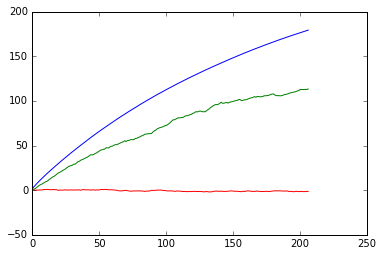

In [24]:
#PLOT ACCUMULATED REWARDS

% pylab inline
import numpy as np
import matplotlib.pyplot as plt

length        = np.minimum(np.size(reward), np.size(best))
reward        = reward[0:length]
best          = best[0:length]
random_reward = random_reward[0:length]

plt.plot(best)
plt.plot(reward)
plt.plot(random_reward)

In [25]:
ratings

[1.0068191825018205,
 -0.024633375307954508,
 0.51227407035499228,
 1.1957254192494027,
 1.3508970022005855,
 1.1628676536856055,
 0.80743962488700805,
 0.64071675371900827,
 1.0310480530704078,
 0.70718706464799685,
 1.1445349999023806,
 0.43468399248817458,
 1.2511982483709678,
 1.1520567546938205,
 0.93094840075362739,
 1.3618799978638414,
 0.47903230674510172,
 1.2647819353626986,
 1.0527461532031011,
 1.4714935496627886,
 0.64968024837112603,
 0.91650550874924785,
 0.79030091672443215,
 1.1292408493507151,
 0.9552733198444715,
 0.69982190115674758,
 1.2629398396626941,
 1.0303764025081443,
 0.84015653023539294,
 0.27104621567291798,
 0.58992382598311743,
 0.9650518380874743,
 0.07807880325673934,
 1.3258983878202697,
 1.2867013533271359,
 0.52314109696368349,
 1.0952168487956073,
 0.8072323024950917,
 0.49987450719738469,
 0.88985783556099562,
 0.64498144792705303,
 0.76391363804754298,
 0.91812341213866322,
 1.3127383182181043,
 0.57148243286744516,
 -0.35612526328768596,
 0.8646

In [ ]:
#PLOT REGRET

plt.plot(best-reward)
plt.plot((best-random_reward))

In [ ]:
W.eval()